In [1]:
import sys, os, glob, time
import numpy as N
import subprocess as sp
import pylab as pl
# import matplotlib.pyplot as pl

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
rc('font',**{'family':'serif'})

time_init_start = time.time()

In [2]:
# ==============================================
# Read.& proc. toolkit for data sets' structure.
# ==============================================

class UserTools(object):
    """
    User-activated tools that are used in the readProcedures instance.
    """
    def __init__(self):
        # Purely for debugging reasons
        if sys.platform in ("linux", "linux2"):
            self.uname = os.path.expanduser("~")+"/"
            pass
        elif sys.platform in ("win32", "win64"):
            self.uname = os.path.expanduser("~")+"\\"
            pass
        else:
            sys.exit("Error in UserTools' init.")
        """
        End of init
        """

    def box_indexer(self, pos, box_params):
        """
        Extracts slices of data, determined from 3D positions.
        self.box_params = [ [0.,20.],[0.,20.],[0.,5.] ] 
        """
        print "  * Boxing indexation commenced "
        xmin, xmax = box_params[0]
        ymin, ymax = box_params[1]
        zmin, zmax = box_params[2]

        " Bool'ed indexation "
        box3D =  N.array( pos[:,0] >= xmin ) \
               * N.array( pos[:,1] >= ymin ) \
               * N.array( pos[:,2] >= zmin ) \
                                             \
               * N.array( pos[:,0] <= xmax ) \
               * N.array( pos[:,1] <= ymax ) \
               * N.array( pos[:,2] <= zmax )

        print "  * Boxing indexation retrieved "

        return box3D

    
    def arrboxes(self, IDs, pos, arr2, box_params):
        """
        Simple function to minimize command lines, returns a boxed array.
        """
        print "  * Applying box "
        box3D = self.box_indexer(pos, box_params)
        IDs   =  IDs[box3D]
        pos   =  pos[box3D]
        arr2  = arr2[box3D]
        print "  * Box applied \n"

        return IDs, pos, arr2 # Because 'arr2' could be a FoF-thing or something...

    
    def sort_from_IDsF(self, IDsA, posA=None, velA=None, focus="what"):
        """
        Sorts IDs, and an accompanying array after sorted IDs.
        focus is meant to be a string object, taking arguments either:
        * "pos"    (- velocity array is returned as None          )
        * "vel"    (- position array is returned as None          )
        * "posvel" (- in case user wants both sorted and returned )
        """
        print "  * Sorting IDs now ..." # ..need this sorted anyway.
        IDsSargA = N.argsort(IDsA)
        IDsA = IDsA[IDsSargA]
        print "    \=> IDs sorted."

        if focus == "pos":
            " Sorts positions "
            
            print "  * Sorting positions."
            posA = posA[IDsSargA]
            print "    \=> positions' array now sorted by ID tag.\n"
            return IDsA, posA

        elif focus == "vel":
            " Sorts velocities"
            
            print "  * Sorting velocities."
            velA = velA[IDsSargA]
            print "    \=> velocities' array now sorted by ID tag.\n"
            return IDsA, velA

        elif focus == "posvel":
            " Sorts both "

            print "  * Sorting positions."
            posA = posA[IDsSargA]
            print "    \=> positions' array now sorted by ID tag.\n"
            # ------------------------------ #
            print "  * Sorting velocities."
            velA = velA[IDsSargA]
            print "    \=> velocities' array now sorted by ID tag.\n"
            return IDsA, posA, velA

        elif focus == "what":
            " User has not input anything to focus on, will assume positions.. "
            self.sort_from_IDsF(IDsA=IDsA, posA=posA, velA=None, focus="pos")
            return 0

        else:
            sort_of_errortext = " Sorting selector test failed (!?!) "
            pass

        print sort_of_errortext
        return 0
    

    #### REWRITE THESE TO BE LESS DEPENDENT ON INSTANCE VARIABLES

    def outputPather(self, folderPath, fileName):
        """
        Checks if output folder structure exists
        & creates output path for output file 
        & filepath- & name based on env. params.
        * Note: based in user's home folder,
                folder structure based on intended task.
        """

        folderPath = folderPath+fileName

        self.fileName = fileName 

        if not os.path.exists(self.uname + folderPath):
            os.makedirs(self.uname + folderPath)
            print "    Creating output folder structure: ", \
                   self.uname + folderPath
            pass
        else:
            print "    Output folder already exists: ", \
                   self.uname + folderPath
            pass

        self.outfilePath = self.uname + folderPath # This is easier, anyway.

        return self.outfilePath


    # Useful functions below

    def linewriter(self, datalist, w):
        """
        This is a function that will write listed data as needed
        """
        maxlen = len(datalist)

        lineToWrite = ""
        for i in range(len(datalist)):
            lineToWrite += "{0:>20}".format(datalist[i])
            continue

        w.write(lineToWrite)
        return 0


    def funcNameOver(self, where="1up"):
        """
        :return: Name of nested function in which this function is called.
        Useful for debugging.
        """
        ranks = {"inception": 0, "here": 1, "1up": 2, "2up": 3}
        return str(sys._getframe(ranks[where]).f_code.co_name)


    def boolcheck(self, arg):
        """ Don't want random user input cluttering;
        only allows 1 and True as boolean statements from user. """
        return any([arg == 1, arg == True])


    def not_NoneFalse(self, arg):
        """ I need SOME kind of check...
        Returns True when arg's value is true.
        """
        return all([arg != 0, arg != False, arg != None])

In [3]:
# ==============================================
# Reading toolkit for data sets' structure.
# ==============================================

class MiscTools(object):
    """
    Miscellaneous tools that are used in the readProcedures instance.
    """
    def __init__(self):
        self.mult_miss_error = \
            """
            File(s) are missing.
            Maybe the dataset should be properly completed first?
            Aborting!
            =========
            """
        self.printNth = 5
        if sys.platform in ("linux", "linux2"):
            self.uname = os.path.expanduser("~")+"/"
            pass
        elif sys.platform in ("win32", "win64"):
            self.uname = os.path.expanduser("~")+"\\"
            pass
        else:
            sys.exit("Error in MiscTools' init.")
            # Purely for debugging reasons
        """
        End of init
        """

    def auto_outputPather(self, num):
        """
        Checks if output folder structure exists
        & creates output path for output file 
        & filepath- & name based on env. params.
        * Note: based in user's home folder,
                folder structure based on intended task.
        """
        self.outfilePath = None

        if bool(self.outputpath) == True:
            " User input specified data output path "
            folderPath = self.outputpath
            pass
        else:
            folderPath = "output_gravipy/{0}_i{1}{2}{3}{4}_sf{5}/"
            pass

        fileName = "{0}_i{1}{2}{3}{4}_sf{5}"
        if self.what == "posvel":
            pass
        else:
            pass

        if self.boolcheck(self.tmpfolder) == True:
            " When 'indraX_tmp' data is processed "
            folderPath = folderPath.format( 
                            self.what, self.indraN, self.iA, self.iB, "tmp", num )
            fileName   = fileName.format(   
                            self.what, self.indraN, self.iA, self.iB, "tmp", num )
            # Examples   : \
            " folderpath : 'output_gravipy/{0}_i{1}{2}{3}{tmp}_sf{5}/' "
            " filename   :                '{0}_i{1}{2}{3}{tmp}_sf{5}'  "
            pass
        else:
            " When normal data structures are processed "
            folderPath = folderPath.format( 
                            self.what, self.indraN, self.iA, self.iB, "", num )
            fileName   = fileName.format(   
                            self.what, self.indraN, self.iA, self.iB, "", num )
            # Examples   : \
            " folderpath : 'output_gravipy/{0}_i{1}{2}{3}{None}_sf{5}/' "
            " filename   :                '{0}_i{1}{2}{3}{None}_sf{5}'  "
            pass
        
        self.fileName = fileName 
        outfilePath = folderPath + fileName

        " If output is requested "
        if any((self.w2f, self.plotdata)) == True:
            " Check if folder already exists; if not then make it "
            if not os.path.exists(self.uname + folderPath):
                os.makedirs(self.uname + folderPath)
                print "Creating output folder structure: ", \
                       self.uname + folderPath, "\n"
                pass
            else:
                print "Output folder already exists: ", \
                       self.uname + folderPath, "\n"
                pass
            pass # Folders verified

        self.outfilePath = self.uname + outfilePath 

        return self.outfilePath


    def itertextPrinter(self, itertext, i, iterLen, modifier):
        " Less spam in terminal window "
        if self.boolcheck(self.lessprint) == False:
            # No output reduction:
            print itertext
            pass
        else:
            # Output reduction:
            if i % (self.printNth*modifier) == 0:
                print itertext
                pass
            elif i == (iterLen-1):
                print itertext
                pass
            else:
                # When no progress is printed as output.
                pass
            pass
        return 0


    def item_size_printer(self, byte):
        """ 
        Paired with 'item_size_calc'
        (which currently does not work reliably);
        takes number of bytes as int,
        then gives out string of human-readable size estimate.
        """
        if 0 <= byte < int(1.e3):
            return "{0:.2f} bytes".format(byte)
        elif int(1.e3) <= byte < int(1.e6):
            return "{0:.2f} KBs".format(byte/1e3)
        elif int(1.e6) <= byte < int(1.e9):
            return "{0:.2f} MBs".format(byte/1e6)
        elif int(1.e9) <= byte < int(1.e12):
            return "{0:.2f} GBs".format(byte/1e9)
        elif int(1.e12) <= byte < int(1.e15):
            return "{0:.2f} TBs".format(byte/1e12)
        elif int(1.e15) <= byte < int(1.e18):
            return "{0:.2f} PBs".format(byte/1e15)
        elif int(1.e18) <= byte < int(1.e21):
            return "{0:.2f} EBs".format(byte/1e18)


    def linewriter(self, datalist, w):
        """
        This is a function that will write listed data as needed
        """
        maxlen = len(datalist)

        lineToWrite = ""
        for i in range(len(datalist)):
            lineToWrite += "{0:>20}".format(datalist[i])
            continue

        w.write(lineToWrite)
        return 0


    def funcNameOver(self, where="1up"):
        """
        :return: Name of nested function in which this function is called.
        Useful for debugging.
        """
        ranks = {"inception": 0, "here": 1, "1up": 2, "2up": 3}
        return str(sys._getframe(ranks[where]).f_code.co_name)


    def boolcheck(self, arg):
        """ Don't want random user input cluttering;
        only allows 1 and True as boolean statements from user. """
        return any([arg == 1, arg == True])


    def not_NoneFalse(self, arg):
        """ I need SOME kind of check...
        Returns True when arg's value is true.
        """
        return all([arg != 0, arg != False, arg != None])


    #   The next functions may have had sound ideas,
    # but are of negligible importance.

    def readLoopError(self, filepath, loop, loops, i):
        """
        *  In case an intermediate file is missing, have an option ready.
        ** In case 2 intermediate files are missing, abort.
        Missing-file-error-handler.
        ... Outdated; useless?!?
            ... Just in case.
        """
        errorstring = \
        """
        Whilst reading {0} dataset,
        Filepath :    {1}  ;
        Reading loop: {2}/{3} ;
        File no. {4} seems to be missing.
        Continue anyway? 
        """.format(self.what, filepath, loop, loops, i)

        self.missingfiles += 1
        if self.missingfiles < 2:
            if self.errhand_userinput(errorstring):
                # Function should return True
                # if user accepts a single missing file
                return 0
            pass
        else:
            # Two missing files is/are/blah too much
            sys.exit(self.mult_miss_error)

        return 0

In [4]:
# ==============================================
# File interpreters for read.py's interface.
# ==============================================

class Sifters(object):
    """
    The down-to-the-byte data sifters.
    """
    def __init__(self):
        # self.bitmask      = N.int64(2**34 - 1) # these are both\
        self.bitshiftmask = (N.int64(1)<<34) - 1 # the same value!
        """
        shortest init yet... not a lot is needed! :/
        """

    def findCount(self, almostpath):
        """
        To figure out the count integer of last file:
        these filenames need to be sorted;
        by way of "human"/"natural" sorting.
        """
        pathstrlen  = len(almostpath) # i.e. snappath is 49 characters long
        filelist    = glob.glob(almostpath+'*')
        filenumbers = []
#         print almostpath
#         print filelist
        for filename in filelist:
            filenumbers.append(filename[pathstrlen:])
            continue # Could have used numpy array ops for this

        filenumbers.sort(key=float)
        maxfileCount = N.int32(filenumbers[-1])

        return maxfileCount 


    def posvel_sifter(self, f, i):
        """
        Sifts through the position/velocities file's data content.
        'f' is the file object for data retrieval.
        """
        header_size = N.fromfile(f, N.int32, 1)[0] # = 256: error catch here?
        numpart     = N.fromfile(f, N.int32, 6)
        npart       = numpart[1] # Number of DM-particles in this file

        mass  = N.fromfile(f, N.float64, 6)
        pmass = mass[1]     # In units of 10^10 solar masses?
        
        scalefact, redshift     = N.fromfile(f, N.float64, 2)
        flag_sfr, flag_feedback = N.fromfile(f, N.int32, 2)
        
        numpart_tot = N.fromfile(f, N.int32, 6) # not used
        # ntotal = numpart_tot[1]                 # not used
        
        flag_cooling, num_files                   = N.fromfile(f, N.int32, 2)
        boxsize, omega0, omegal, hubble           = N.fromfile(f, N.float64, 4)
        flag_stellarage, flag_metals, hashtabsize = N.fromfile(f, N.int32, 3)
        # Read rest of header_size + 2 dummy integers:
        dummy = N.fromfile(f, dtype=N.int32, count=23)
        # So in total a count of 21 units of useless header info
        # w/in header_size, and 2 dummy ints.

        pos = N.fromfile(f, N.float32, 3*npart)
        pos = N.reshape(pos, [npart, 3])# .astype(N.float64)
        # This is the way to format for row-major use!
        """
        The velocities were initially listed in the 'redshift's else:section,
        because they're not needed in the "main" program,
        for which this was written,
        unless when redshift was investigated?
        """
        dummy = N.fromfile(f, N.int32, 2)
        vel   = N.fromfile(f, N.float32, 3*npart)
        vel   = N.reshape(vel, [npart, 3])#.astype(N.float64)
        
        """
        Looking at read_indra_snap.pro and other snippet;    
        looks like this will read the assigned IDs:
        """
        dummy = N.fromfile(f, N.int32, 2)
        idarr = N.fromfile(f, N.int64, npart)

        f.close()
        return pos, vel, idarr, npart


    def fof_tab_sifter(self, f, i, skip):
        """
        Sifts through the group tab data
        """
        # print "Before if of fof_tab_sifter"
        Ngroups, Nids, TotNgroups, NTask = N.fromfile(f, N.int32, 4)
        # should there be a dummy distance between this and the next information, or..?
        # 8==> apparently not!
        # print Ngroups, Nids, TotNgroups, NTask
        # print "\nBefore if-conditions:"
        # print "TotNgroups > 0: i=", i, "TotNgroups=", TotNgroups, \
        #         "Ngroups=", Ngroups, "\n"
        
        # print "i is simply a variable in python 2.6 environment.\nHere are some tests for bools. Have fun with this logic..."
        # print "i-test: * i is 0:", i is 0, ", * i == 0:", i == 0 
        # print "i-test: * i is not 0:", i is not 0, ", * i != 0:", i != 0 
        # print "str-test: * 'str' is 'str':", 'str' is 'str',\
        #       ", * 'str' == 'str':", 'str' == 'str' 

        # print "type-test: * type('str') is str:", type('str') is str,\
        #       ", * type('str') == str:", type('str') == str

        # print "str-test: * 'str' is not 'ok':", 'str' is not 'ok',\
        #       ", 'str' != 'ok':", 'str' != 'ok'
        if i == 0:
            print "i          = " + str(i)          + "\n"+ \
                  "Ngroups    = " + str(Ngroups)    + "\n"+ \
                  "Nids       = " + str(Nids)       + "\n"+ \
                  "TotNgroups = " + str(TotNgroups) + "\n"
            # self.linewriter(                        \
            #     ["Ngroups=" + str(Ngroups),     \
            #      "Nids="    + str(Nids),        \
            #      "TotNgroups="+str(TotNgroups)] , self.writeToFile)
                    # Header for file.

        if i == 0 and TotNgroups > 0:
            # print "inside first if"
            self.GroupLen    = N.zeros(TotNgroups, dtype=N.int32) # DNC 
            self.GroupOffset = N.zeros(TotNgroups, dtype=N.int32) # DNC
            pass # offset? what is this' purpose?
        # print "Between if-conditions.\n"
        if Ngroups > 0:
            # print "Inside second if! \n"
            locLen      = N.fromfile(f, N.int32, Ngroups)
            locOffset   = N.fromfile(f, N.int32, Ngroups)
            # print "locLen", locLen
            # print "Ngroups > 0:", i, TotNgroups
            self.GroupLen[    skip:skip+Ngroups ] = locLen[:]
            self.GroupOffset[ skip:skip+Ngroups ] = locOffset[:]

            # raw_input("Ngroups > 0!")
            skip += Ngroups
            pass
        # print "After conditions\n"
        f.close()
        # self.linewriter([Ngroups, Nids, TotNgroups], self.writeToFile)

        if self.bssdt == True:
            for item in self.GroupLen:
                """
                because GroupLen is 'iterable', even when GroupLen's empty;
                and we only need its first value.
                ... and it doesn't even raise errors when 'item' doesn't exist...
                """
                print "Len of GroupLen", len(self.GroupLen)
                setattr(self, length, item)
                break
            pass

        if i == 255: # DT
            print "i          = " + str(i)          + "\n" + \
                  "Ngroups    = " + str(Ngroups)    + "\n" + \
                  "Nids       = " + str(Nids)       + "\n" + \
                  "TotNgroups = " + str(TotNgroups) + "\n"

        # print "After if of fof_tab_sifter"
        return Ngroups, Nids, TotNgroups, skip


    def fof_ids_sifter(self, f, i, skip):
        """
        Sifts through the group ID data
        """
        Ngroups, Nids, TotNgroups, NTask = N.fromfile(f, N.int32, 4)
        if TotNgroups > 0:
            TotNids = N.sum(self.GroupLen, dtype=N.float64)
            pass
        else:
            TotNids = N.float64(0)
            pass

        if i == 0 and TotNids > 0:
            self.IDs = N.zeros(TotNids, dtype=N.int64)       # LIDA
            pass

        if Nids > 0:
            locIDs = N.fromfile(f, N.int64, Nids)  # LIDA
            self.IDs[ skip:skip+Nids ] = \
                    N.bitwise_and(locIDs[:], self.bitshiftmask)
            skip += Nids  # \___|: Reading binary/bitwise. Not all of the data
            pass          #  \__|  is what we're actually looking for.

        f.close()
        return skip


    def sub_Totes_counter(self, f, TotNSubs):
        """
        Counts TotNsubs.
        Last value of TotNgroups is also produced.
        Necessary to construct arrays properly in next sifter.
        Decided against using this, the 3 necessary lines are now in read_tools.
        """
        Ngroups, Nids, TotNgroups, NTask, NSubs = N.fromfile(f, N.int32, 5)
        f.close()
        TotNsubs += NSubs
        return Ngroups, Nids, TotNgroups, NSubs, TotNsubs


    def sub_tab_sifter(self, f, SubLen, SubOffset, M200, count, count_sub, pos, skip, i):
        """
        Sifts through tab files.
        Collects identifications of no. of sub halos and structures?
        """
        Ngroups, Nids, TotNgroups, NTask = N.fromfile(f, N.int32, 4)
        # print 'Ngroups      = ', Ngroups
        # print 'TotNgroups   = ', TotNgroups
        Nsubs = N.fromfile(f, N.int32, 1)
        """
        ; Why would Nsubs be 0? ... in this certain file?
        """
        if Nsubs > 0:

            NsubPerHalo     = N.fromfile(f, N.int32, Ngroups)
            FirstSubOfHalo  = N.fromfile(f, N.int32, Ngroups)
            locLen          = N.fromfile(f, N.int32, Nsubs)
            locOffset       = N.fromfile(f, N.int32, Nsubs)
            SubParentHalo   = N.fromfile(f, N.int32, Nsubs)

            SubLen[    skip:skip+Nsubs ] = locLen[:]
            SubOffset[ skip:skip+Nsubs ] = locOffset[:]
                
            skip += Nsubs
            # print "Nsubs= ", Nsubs, N.sum(loclen, dtype=N.float64) # LDT

            Halo_M_Mean200   = N.fromfile(f, N.float32, Ngroups)
            Halo_R_Mean200   = N.fromfile(f, N.float32, Ngroups)
            Halo_M_Crit200   = N.fromfile(f, N.float32, Ngroups)
            Halo_R_Crit200   = N.fromfile(f, N.float32, Ngroups)
            Halo_M_TopHat200 = N.fromfile(f, N.float32, Ngroups)
            Halo_R_TopHat200 = N.fromfile(f, N.float32, Ngroups)

            M200[ count:count+Ngroups ] = Halo_M_Crit200

            SubPos          = N.fromfile(f, N.float32, Nsubs*3)
            SubVel          = N.fromfile(f, N.float32, Nsubs*3)
            SubVelDisp      = N.fromfile(f, N.float32, Nsubs)
            SubVmax         = N.fromfile(f, N.float32, Nsubs)
            SubSpin         = N.fromfile(f, N.float32, Nsubs*3)
            SubMostBoundID  = N.fromfile(f, N.int32  , Nsubs*2)
            Subhalfmass     = N.fromfile(f, N.float32, Nsubs)

            SubPos          = N.reshape(SubPos, [Nsubs, 3])#.astype(N.float64)
            SubVel          = N.reshape(SubVel, [Nsubs, 3])#.astype(N.float64)
            SubSpin         = N.reshape(SubSpin, [Nsubs, 3])#.astype(N.float64)
            SubMostBoundID  = N.reshape(SubMostBoundID, [Nsubs, 2])#.astype(N.float64)
                                            # should these be converted to float64?
            
            print "i:", i
            print "FirstSubOfHalo             :", FirstSubOfHalo
            print "len(FirstSubOfHalo)        :", len(FirstSubOfHalo)
            print
            print "uniques FirstSubOfHalo     :", N.unique(FirstSubOfHalo)
            print "len(uniques FirstSubOfHalo):", len(N.unique(FirstSubOfHalo)),"\n"

            print
            print "differences that SHOULD >= 0 ?? :"
            print "----------------------------------------------------------"
            print "len(FSOH) - len(FSOH.uniq)                 =", \
                  len(FirstSubOfHalo) - len(N.unique(FirstSubOfHalo))
            print "len(SubPos[FSOH]) - len(SubPos[FSOH.uniq]) =", \
                  "not testable"# len(SubPos[FirstSubOfHalo,0]) - len(SubPos[N.unique(FirstSubOfHalo)])

            print 
            print "differences that SHOULD == 0:"
            print "----------------------------------------------------------"
            print "shape(SubPos) :",\
                  N.shape(SubPos)
            print "shape(SubPos[N.unique(FirstSubOfHalo) , 0]) :",\
                  N.shape(SubPos[N.unique(FirstSubOfHalo) , 0])

            print "len(pos[sel]) - len(SubPos[FSOH.uniq])     =", \
                  len(pos[ count:count+Ngroups , 0 ]) - \
                  len(SubPos[N.unique(FirstSubOfHalo) , 0])
            print "len(pos[sel]) - len(SubPos[FSOH])          =", \
                  len(pos[ count:count+Ngroups , 0 ]) - \
                  len(SubPos[FirstSubOfHalo , 0])

            print
            print "shapes:"
            print "pos:", N.shape(pos), " - SubPos:", N.shape(SubPos)
            print "pos[   sele:ction , : ]:", N.shape(pos[ count:count+Ngroups , : ])
            print "SubPos[ FSOH.uniq , : ]:", N.shape(SubPos[ N.unique(FirstSubOfHalo) , : ])
            print "SubPos[      FSOH , : ]:", N.shape(SubPos[ FirstSubOfHalo , : ])
            print 
            print "=========================================================="
            print 

            if i == 5:
                pvc = 0 # Paired Valuces Counter
                pairedValsIn = [] # indices
                for in1 in range(len(FirstSubOfHalo)):
                    if FirstSubOfHalo[in1] == N.unique(FirstSubOfHalo)[pvc]:
                        print "in1: {0:>4} := FSOH[in1]: {1:>4} --- ".format(  \
                                      in1, FirstSubOfHalo[in1]           ) +   \
                              "in2: {0:>4} := FSOH.uniq[in2] {1:>4}".format(   \
                                      pvc, N.unique(FirstSubOfHalo)[pvc] )
                        pairedValsIn.append(pvc)
                        pvc += 1
                        pass
                    else:
                        print "in1: {0:>4} := FSOH[in1]: {1:>4} --- ".format(  \
                                      in1, FirstSubOfHalo[in1]           )
                        pass
                    continue
                pass

            pos[ count:count+Ngroups , : ] = SubPos[ FirstSubOfHalo, : ]
            count += Ngroups
            pass

        # else:
        #     print 'Nsubs = 0'
        f.close()

        # Below running into indexing errors
        # # ind = N.where(sublen > 20) # wait, no, surely you mean:
        # ind = N.argwhere(sublen > 20)
        # if (ind[0] != -1):
        #     num_chos = len(ind)
        #     mass_sub[ count : count+num_chos-1]     = sublen[ind]
        #     pos_sub[ : , count : count+num_chos-1 ] = subpos[ : , ind ]
        #     count_sub = count_sub + num_chos

        # mass_sub[ count : count+ngroups-1 ]     = halo_m_mean200[ : ]
        # pos_sub[ : , count : count+ngroups-1 ]  = subpos[ :, FirstSubOfHalo ]
        # count   = count + ngroups
        # count1  = count1 + nsubs

        return SubLen, SubOffset, M200, count, count_sub, pos, skip

    def sub_ids_sifter(self, SubLen, skip):
        """
        Sifts through ID files.
        Collects IDs. I guess?
        """
        Ngroups, Nids, TotNgroups, NTask = N.fromfile(f, N.int32, 4)
        # print "file=", i
        # print "Ngroups=", Ngroups, "  TotNgroups=", TotNgroups, " Nids=", Nids,\
        #     "  NTask=", NTask

        if TotNgroups > 0:
            TotNids = N.sum(SubLen, dtype=N.float64)
            pass
        else:
            TotNids = N.int64(0)
            pass

        if i == 0 and TotNids > 0:
            IDs = N.zeros(TotNids, dtype=N.int64)   # LIDA
            pass

        if Nids > 0:
            locIDs  = N.fromfile(f, N.int64, Nids)  # LIDA
            # Remove the hash table info:
            IDs[ skip:skip+Nids ] = \
                    N.bitwise_and(locIDs[:], self.bitshiftmask)
            
            skip += Nids
            pass

        # SHOULD PROBABLY WRITE SOMETHING TO FILE HERE, TOO!?!!

        f.close()

        return return_variables # FIGURE THESE OUT TOMORROW

    def fft_sifter(self, f):
        """
        Sifts through FFT data.
        """
        """ # keep this for orientation purposes

        ; fft_re=fltarr(Lhalf+1,L+1,L+1) # looks like a zeros-function, specifically float32
        ; fft_im=fltarr(Lhalf+1,L+1,L+1) # if IDL does j,i,k - then python does i,j,k ...?
        
        #=> becomes the below statements, and shows dimensions:
            IDL IS COL-MAJOR,
            PYTHON IS ROW-MAJOR
        """
        # PMGRID  = N.int32(640) # not used for anything...
        L       = N.int32(128)
        Lhalf   = L/2

        time2 = N.fromfile(f, N.float64, 1)
        nsize = N.fromfile(f, N.int32, 1) # long integer, should display value
                                          # (Lhalf+1)*(L+1)*(L+1)
        print 'time2:  ', time2
        print 'nsize:  ', nsize

        fft_re = N.fromfile(f, N.float32, (L+1)*(Lhalf+1)*(L+1) )
        fft_re =   N.reshape(fft_re, [L+1, Lhalf+1, L+1] ).astype(N.float64)

        fft_im = N.fromfile(f, N.float32, (L+1)*(Lhalf+1)*(L+1) )
        fft_im =   N.reshape(fft_im, [L+1, Lhalf+1, L+1] ).astype(N.float64)

        f.close()

        return time2, nsize, fft_re, fft_im


    def origami_sifter(self, f):
        """
        Sifts through Origami binary data.
        """
        npart = N.fromfile(f, N.int32, 1)
        tag   = N.fromfile(f, N.int8, npart)
        return npart, tag


In [5]:
# ==============================================
# Reading procedure for data sets' structure.
# ==============================================

class readProcedures(Sifters, MiscTools, UserTools):
    """
    Contains structures which read the data in question.
    I.o.w.: Every read_*-function shows the program flow of reading procedures.
    Misc. tools for post-processing or other functionalities 
      are imported from read_*tools classes.
    """
    def __init__(self):
        """
        Inheritance and variables
        """
        Sifters.__init__(self)
#         AutoTools.__init__(self) # Remember proc. argument
        MiscTools.__init__(self)
        UserTools.__init__(self)
        self.missingfiles = 0
        # Counter - assumes only 1 type of dataset will be read.

        # DT
        self.dummypath1 = '/datascope/indra%d/%d_%d_%d' % (0, 0, 0, 0)
        self.dummypath2 = '/snapdir_%03d/snapshot_%03d.' % (0, 0)
        """
        End of init           # but will halt if there's more, inside func below.
        """

    def read_posvel(self):
        """
        Analyzes positions and velocities dataset.
        """
        indrapath = self.dsp + self.indraPathParser()
        snappath = indrapath + '/snapdir_{0:03d}/snapshot_{0:03d}.'\
                                .format(self.subfolder)
        # + particular count, comes in the for-loop ## dataset and indra path
        maxfileCount = self.findCount(snappath)
        iterLen      = maxfileCount + 1
        """
        Total no. of particles is set.
        """
        Npart_tot = 1024**3
        posA      = N.zeros( (Npart_tot,3), dtype=N.float32 )
        velA      = N.zeros( (Npart_tot,3), dtype=N.float32 )
        IDsA      = N.zeros(  Npart_tot   , dtype=N.int64   )
        NpartA    = N.zeros(  iterLen     , dtype=N.int64   )

        readtext = "  * Accessing file:\tindra{0}{1}/snap{2}/file.{3:<3} ({4}) ..."
        tmpftxt  = "tmp" if self.tmpfolder == True else ""

        ci = 0 # Current index to update
        for i in N.arange(0, iterLen):
            """
            Will cover all files.
            """
            filepath = snappath + str(i)
            try:
                with open(filepath, 'rb') as openfile:
                    pos, vel, IDsArr, Npart = self.posvel_sifter(openfile, i)
                    
                    itertext = readtext.format( self.indraN, tmpftxt, 
                                               self.subfolder, i, self.what )
                    self.itertextPrinter(itertext, i, iterLen, 10)

                    # End shape: ( 1024**3 , 3 )
                    # print "posA[ci:Npart, :].shape : ", posA[ci:ci+Npart, :].shape 
                    # print "pos (from file).shape   : ", pos.shape
                    posA[ci:ci+Npart, :] = pos
                    velA[ci:ci+Npart, :] = vel
                    IDsA[ci:ci+Npart]    = IDsArr
                    NpartA[i]            = Npart

                    ci += Npart

                continue # Next binary file's turn

            except IOError:
                self.readLoopError(filepath, 1, 1, i)
                pass

            continue # Next binary file's turn

        # File reading loop completed; print status
        countedNpart = N.sum(NpartA)
        maxN         = N.max(NpartA)
        Intermission = """
    Byte sifter completed. 
    Max particle number in a file:      {0}
    Sum particles read / Tot. in sim.:  {1:g} / {2:g} ( {3:g}% )
    Maximum indra particles read?:      {4}""".format( 
            maxN, countedNpart, 1024**3, 100*countedNpart/(1024.**3.),
            (countedNpart==1024**3) )
        print Intermission
        matsizes = IDsA.nbytes + posA.nbytes + velA.nbytes + NpartA.nbytes
        print "    Size of matrices IDsA, posA, velA, NpartA = " \
               + self.item_size_printer(matsizes) 

        # ID sorting block
        if self.boolcheck(self.sortIDs):
            print """
    Sifter has completed reading all {0} files of snap {1}.
    - Commencing method for sorting positions and velocities."""\
                            .format(iterLen, self.subfolder)
            IDsA, posA, velA = self.sort_from_IDsF(IDsA, posA, velA, self.what)
            pass

        # The reading is done, the bells have toll'd;
        # print out the stats, parameters, and all!
        endread = "\n    Finished reading '"+str(self.what)+"' of files, indra"\
                +str(self.indraN)+', iA='+str(self.iA)+', iB='+str(self.iB)    \
                +', snapshot='+str(self.subfolder)+"\n"
        if self.boolcheck(self.sortIDs):
            endread+="     - and matrices are now sorted after IDs' values.\n"
            pass
        print endread

        " returns what user needs, specifically: "
        if self.what == "pos":
            return IDsA, posA

        elif self.what == "vel":
            return IDsA, velA

        else:
            sys.exit("\n    *** read_posvel task name error *** \n")
            # What the fuck


    def read_FOF(self):
        """
        Reads friend of friend/group files' id and tab files;
        Takes care of the loops,
        engages byte sifters in each loop.
        Basic error handling.
        """
        indrapath = self.dsp + "/indra%d/%d_%d_%d" \
            % (self.indraN, self.indraN, self.iA, self.iB)
        snappath = indrapath + "/snapdir_%03d/" % (self.subfolder)
        gtb = snappath + "group_tab_%03d." % (self.subfolder)
        gid = snappath + "group_ids_%03d." % (self.subfolder)

        skip = 0
        maxfileCount_gtb = self.findCount(gtb)

        for i in N.arange(0, maxfileCount_gtb + 1):
            """
            will cover all files.
            in case an intermediate file is missing, have an option ready.
            in case 2 intermediate files are missing, abort.
            """
            filepath = gtb + str(i)
            
            with open(filepath, 'rb') as openfile:
                
                try:
                    fts_output = self.fof_tab_sifter(openfile, i, skip)
                    Ngroups, Nids, TotNgroups, skip = fts_output

                    pass

                except IOError:
                    self.readLoopError(filepath, 1, 2, i)
                    pass

            continue

            # need matrices for these variables to be stored in?
            # file storage probably better

        # print "\n", "TotNgroups    =", TotNgroups, \
        #       "\n\nLargest group of length ", self.length

        if self.sub_asks_for_length == True: # enabling LDT
            return 0 # self.length has been set already, now exiting func 
                     # to continue down in read_sub.
        """
        --------select the biggest subhalo in the first group 
        --------load all of the IDs
        """

        skip = 0    # resetting the variable.
        maxfileCount_gid = self.findCount(gid)

        for i in N.arange(0, maxfileCount_gid + 1):
            """
            will cover all files.
            in case an intermediate file is missing, have an option ready.
            in case 2 intermediate files are missing, abort.
            """
            filepath = gid + str(i)
            
            with open(filepath, 'rb') as openfile:
                
                try:
                    fis_output = self.fof_ids_sifter(openfile, i, skip)
                    skip = fis_output
                    pass

                    if self.bssdt == True: # Big Skip ShutDown Toggle
                        if skip > 1.01*self.length:
                            print "\n skip > 1.01*length - encountered;\n " \
                                    +"reading", self.what, "data;\n "       \
                                    +"for-loop aborted at \n"+filepath
                            return 0

                except IOError:
                    self.readLoopError(filepath, 2, 2, i)
                    pass

            continue

        self.GroupLen = None # Making sure this variable is clear before beginning
                             # of next case in case of multi-run set ups.
        print "Finished reading '"+str(self.what)+"', indra"       \
                +str(self.indraN)+', iA='+str(self.iA)+', iB='+str(self.iB)  \
                +', snapshot='+str(self.subfolder)
        
        return 0


    def read_subhalo(self):
        """
        Reads subhalo id and tab files.
        """
        indrapath = self.dsp + "/indra%d/%d_%d_%d" \
            % (self.indraN, self.indraN, self.iA, self.iB)
        postpath = indrapath + "/postproc_%03d/" % (self.subfolder)
        stb = postpath + "sub_tab_%03d." % (self.subfolder) # sub tab file name
        sid = postpath + "sub_ids_%03d." % (self.subfolder)
        
        nnn         = N.int32(500000)
        # mass_sub   = N.zeros(nnn, dtype=N.float32)    # LDT
        # pos_sub    = N.zeros((3,nnn), dtype=float32)  # LDT
        # First need total # subhalos, not saved like TotNgroups...
        TotNsubs    = N.int32()
        
        self.missingfiles = 0
        maxfileCount_stb  = self.findCount(stb)
        for i in N.arange(0, maxfileCount_stb +1): # [0, 255]   
            """
            will cover all files.
            in case an intermediate file is missing, have an option ready.
            in case 2 intermediate files are missing, abort.
            """
            filepath = stb + str(i)
            
            with open(filepath, 'rb') as openfile:
                
                try:
                    # sTc_output = self.sub_Totes_counter(openfile, TotNsubs)
                    # Ngroups, Nids, TotNgroups, NSubs, TotNsubs = sTc_output

                    # Rewriting this loop's contents into a function,
                    # is _not strictly very necessary_.
                    # The loop's contents is short enough.
                    # Will function as a good check for the tab-files, though.
                    # Keeping the check, simplifying:

                    Ngroups, Nids, TotNgroups, NTask, NSubs = \
                                        N.fromfile(openfile, N.int32, 5)
                    openfile.close()
                    TotNsubs += NSubs
                    pass

                except IOError:
                    self.readLoopError(filepath, 1, 3, i)
                    pass


            continue
        """    
        ### ----------------------- END OF LOOP 1/3 ABOVE
        ### TotNsubs NOW FOUND, as well as TotNgroups from last iteration
        ### ----------------------- NEXT LOOP   2/3 BELOW
        """
        skip        = 0
        count       = 0
        count_sub   = 0     # only used in commented lines
        # next declarations: necessary? -------------------------\
        SubLen      = N.zeros(TotNsubs, dtype=N.int32)          #| DNC
        SubOffset   = N.zeros(TotNsubs, dtype=N.int32)          #| DNC
        M200        = N.zeros(TotNgroups, dtype=N.float32)      #| DNC
        # pos         = N.zeros(TotNgroups*3, dtype=N.float32)    #| DNC
        pos         = N.zeros((TotNgroups,3), dtype=N.float32)  #| DNC
        # -------------------------------------------------------/
        self.missingfiles = 0
        for i in N.arange(0, maxfileCount_stb + 1): # [0, 255]

            filepath = stb + str(i)

            with open(filepath, 'rb') as openfile:

                try:
                    sts_output = self.sub_tab_sifter(openfile, SubLen, \
                                 SubOffset, M200, count, count_sub, pos, skip, i)
                    SubLen, SubOffset, M200, count, count_sub, pos, skip = sts_output
                    pass
                except IOError:
                    self.readLoopError(filepath, 2, 3, i)
                    pass
            continue
        # pos = N.reshape(pos, ) # Can't do it until it's filled!:)


        # mass_sub  = mass_sub[ 0:count_sub-1 ]
        # pos_sub   = pos_sub[ : , 0:count_sub-1 ]
        
        # print "\n ",  TotNgroups   =", TotNgroups
        # print ""\n ", Largest group of length ", GroupLen[0]
        """
        ### ----------------------- END OF LOOP 2/3 ABOVE
        ;-------select the biggest subhalo in the first group 
        ;-------load all of the IDs
        ### ----------------------- NEXT LOOP   3/3 BELOW
        """
        self.loadIDs = True # implement user argument if wanted.

        if keyword_set(self.loadIDs):
            
            if self.bssdt == True: # Big Skip ShutDown Toggle
                self.sub_asks_for_length = True ### should be logical consequence.
                self.read_FOF() # LDT - need to run a section of FOF to get this
                                      # one.
            skip    = 0
            self.missingfiles = 0
            maxfileCount_sid  = self.findCount(sid)

            for i in range(0, self.subidCount + 1):
 
                filepath = sid + str(i)
                with open(filepath, 'rb') as openfile:

                    try:
                        sis_output = self.sub_ids_sifter(openfile, \
                                                         TotNsubs, n, other, IDs, i, skip)
                        # exactly what output/input is needed?
                        dummy, IDs = sis_output
                        # DO SOMETHING ABOUT THIS (,) DUMMY! (heh, gedit?)
                        # need matrices for these variables to be stored in?
                        # file storage probably better
                    
                        if self.bssdt == True:
                            if skip > 1.01*self.length: # LDT !
                                print "\n skip > 1.01*length - encountered;\n " \
                                        +"reading", self.what, "data;\n "       \
                                        +"for-loop aborted at \n"+filepath
                                return 0

                    except IOError:
                        self.readLoopError(filepath, 3, 3, i)
                        pass
                continue
            pass

        print "Finished reading '"+str(self.what)+"', indra"                \
                +str(self.indraN)+', iA='+str(self.iA)+', iB='+str(self.iB) \
                +', snapshot='+str(self.subfolder)
        return 0 # stenger

    def read_FFT(self):
        """
        FFT data reading procedure
        """
        indrapath = self.dsp + "/indra%d/%d_%d_%d" \
            % (self.indraN, self.indraN, self.iA, self.iB)
        fftpath = indrapath + '/FFT_DATA/FFT_128_%03d.dat' % self.fftfile

        with open(fftpath, 'rb') as openfile:

            try:
                fft_output = self.fft_sifter(openfile)
                pass

            except IOError:
                self.readLoopError(filepath, 1, 1, i)
                pass
        
        dummy = fft_output # DO SOMETHING ABOUT THIS (,) DUMMY! (heh, gedit?)

        return 0


    def read_origami(self):
        """
        Reads ORIGAMI's data output
        """
        oridatapath = self.origamipath
        ori_open_error_str = """
        Could not find origami file at specified path: {0:s}
        """.format(oridatapath)
        # oridatapath = "/workspace/indra/origami/testrun/"
        try:
            with open(oridatapath, 'rb') as openfile:
                # Npart, tag = self.origami_sifter(openfile)
                Npart = N.fromfile(openfile, N.int32, 1)
                tag   = N.fromfile(openfile, N.int8, Npart)
            pass
        except IOError:
            sys.exit(ori_open_error_str)
            pass

        return Npart, tag

In [6]:
# ==============================================
# Argument interpreter for read.py's interface.
# ==============================================
import sys, os

class readArgs(object):
    """
    Initializes which method to use for parameter initialization;
    Cmd-line reading or cfg-file reading. Some error messages.
    """
    def __init__(self):
        """
        Some versatile error messages included to environment...
        though; fairly sure long strings are conventionally not included to init,
            with regard to common practice in python classes? who cares!
        """
        self.argsOKtext = """
            All necessary parameters have been set. Continuing...
            """
        self.arglisterror = """
            Argument list discrepancy.
            Shutting down.\n"""
        self.inigo = "My name is Inigo Montoya. You killed my father. \
                        Prepare to die.\n\n\tExiting."
        # Error messages get boring after a while.
        self.length              = None  # LDT (from IDL debugs)
        self.sub_asks_for_length = False # enabling LDT for subhalo
        self.okGo                = False # checker for remote debugging 
        self.missingkeys_no = 0
        self.missingkeys    = []
        self.keys_read      = []
        self.onElephant = False
        self.onIdies    = False
        """
        Definitions of keywords to be used, script's interpretation +++.
        When adding a new user input parameter, write it into the below
        init-lists.
        If a new type-checker is needed for an individual purpose;
        then write a new function into the group of functions below.
        """
        self.arglist = \
            [ # Parameter keys available
                "what"       , 
                "indraN"     , 
                "iA"         , 
                "iB"         , 
                "subfolder"  , 
                "fftfile"    , 
                "tmpfolder"  ,
                "sortIDs"    ,
                "lessprint"  ,
                "w2f"        ,
                "plotdata"   ,
                "outputpath" ,
                "box_params" ,
                "plotdim"    ,
                "origamipath"
            ]
        self.param_incorp = \
            { # Function library: parameter validation
                     "what" : self.taskname_incorp   ,
                   "indraN" : self.integer_incorp    ,
                       "iA" : self.integer_incorp    ,
                       "iB" : self.integer_incorp    ,
                "subfolder" : self.integer_incorp    ,
                  "fftfile" : self.integer_incorp    ,
              # Optional stuff
                "tmpfolder" : self.toggles_incorp    ,
                  "sortIDs" : self.toggles_incorp    ,
                "lessprint" : self.toggles_incorp    ,
               "box_params" : self.boxparams_incorp  ,
                  "plotdim" : self.integer_incorp    ,
              # Output related
               "outputpath" : self.outputpath_incorp ,
                      "w2f" : self.toggles_incorp    ,
                 "plotdata" : self.toggles_incorp    ,
              "origamipath" : self.in_path_incorp
            }
        self.intRange_dict = \
            { # Ranges of integer numbers.
                "indraN" : range(0,8),
                    "iA" : range(0,8),
                    "iB" : range(0,8),
             "subfolder" : range(0,64),
               "fftfile" : range(0,505),
               "plotdim" : range(2,4)
            } # Rember format: [x0, ..., x1 - 1]
        """
        Dictionaries: parameter values
        """
        self.read_params = \
            { # None-types are ignored in flow after validation.
                     "what" :["pos"],
                   "indraN" :   0   ,
                       "iA" :   0   ,
                       "iB" :   0   , 
                "subfolder" :  None , 
                  "fftfile" :  None , 
                  "sortIDs" :   1   ,
                "lessprint" :   1   ,
                "tmpfolder" :   0   ,
                      "w2f" :   0   ,
                 "plotdata" :   1   ,
               "outputpath" :  None ,
               "box_params" :   0   ,
                  "plotdim" :   2
            }
        """
        end of init
        """

    def callArgsChecker(self):
        """
        1. Collect parameters are !=None.
           1.1) Show user collected parameters.
        2. Check type(s) of 1.;
            Individual check for each expected type.
           2.1) Tuples or not
            a] Not: Proceed to 3.
            b] Tuple: Check contents for 2.
        3. Check boundaries of value, 
            one range corresponding to each type.
        """
        " 1. "
        self.collect_userArgs()

        " 1.1) Program initialized with... "
        self.loaded_parameters() # Screen-printed overview
        
        for key in self.keys_read:
            " 2. & 3., individual functions " 
            self.param_incorp[key](self.read_params[key], key)
            continue # Less output is good news!
        
        print self.argsOKtext
        return 0


    def collect_userArgs(self):
        """
        Collects parameters defined by user (not 'None').
        """
        # print " ** Inside self.collect_userArgs()"
        for key in self.arglist:
            
            if self.read_params[key] == None:
                self.missingkeys.append(key)
                # self.keys_read.append(key) # Not useful to the user
                pass
            
            elif self.read_params[key] != None:
                self.keys_read.append(key)
                pass

            else:
                print " WTFery-error for key   " , \
                    key , ":" , self.read_params[key]
                pass
            
            continue

        if ("subfolder" not in self.keys_read) and \
                ("fftfile" not in self.keys_read):
            # Oh no!
            neither_fft_sf = """
            Parameters specified contain neither a snapshot number,
            nor an FFT file number. Please include at least one of these.
            """
            sys.exit(neither_fft_sf)

        return 0


    def loaded_parameters(self):
        """
        Screen-printed summary shows what values that  the user 
        has assigned as parameters for the arguments.
        """
        print "\n Total parameters loaded:", len(self.keys_read)
        print " Parameters initialized with values:"
        for key in self.keys_read:
            print "{0:>12s} : {1:>6s}".format( key, \
                   str(self.read_params[key]).strip("") )
            continue
        return 0


    def taskname_incorp(self, uinput, name="what"):
        """
        Incorporates user input task name(s).
        """
        tasknameErrortext = """
        Invalid task name specification(s), or format(s) thereof: {0}
        Allowed task names listed below.
        """.format(uinput)
        column_of_actions = "\t"
        for action in self.actionkeys:
            column_of_actions = column_of_actions+action+"\n"+(8*" ")
            continue

        if (type(uinput) == tuple) or \
            (type(uinput) == list):
            " When multiple tasks are input. "
            
            for taskname in uinput:
                " Check if each name is in library. "
                
                if (type(taskname) == str) and \
                    (taskname in self.actionkeys):
                    " Task name(s) accepted"
                    pass
                else:
                    sys.exit(tasknameErrortext.format(uinput)+column_of_actions)
                    break

                continue

            setattr( self, "what_set" , uinput )
            # Returns, having checked & stored both items in the set.
            return 0

        elif (type(uinput) == str) and \
            (uinput in self.actionkeys):
            " String object recognized, input is compared & stored. "
            setattr( self, "what_set" , uinput )
            # After storing, returns to next item to be checked
            return 0

        else:
            sys.exit(tasknameErrortext.format(uinput)+column_of_actions)
            # Aborts


    def integer_incorp(self, uinput, name):
        """
        Incorporates user input integer number for any ints
        """
        integererrortext = """
        Invalid number specified for {0}: '{1}'.
        Allowed range: integer in [{2},{3}]
        """.format(name, uinput,
                   self.intRange_dict[name][0], self.intRange_dict[name][-1])
        
        if type(uinput) == tuple or \
            type(uinput) == list:
            " When multiple numbers are input. "
            
            if len(uinput) == 2:
                " Only 2 values for limits "
                for single_number in uinput:
                    " Check each number by range. "
                    
                    if (type(single_number) == int) and \
                        (single_number in self.intRange_dict[name]):
                        " Value of number checks out! "
                        pass
                    else:
                        sys.exit(integererrortext)
                        break

                    continue
            else:
                " Multiple values, but not in form of (lower,upper)!"
                sys.exit("""
            Parameter {0} requires exactly 1, or 2 (in tuple or list as lower- and upper-),
            integer(s) as input variable(s).
            """.format(name))

            setattr( self, name+"_set" , uinput    )
            setattr( self, name+"_low" , uinput[0] )
            setattr( self, name+"_high", uinput[1] )
            # Returns, having checked & stored both items in the set.
            return 0

        elif type(uinput) == int and \
            uinput in self.intRange_dict[name]:
            " Int object recognized then input is recognized. "
            setattr( self, name+"_set" , uinput )
            setattr( self, name+"_low" , uinput )
            setattr( self, name+"_high", uinput )
            # After storing, returns to next item to be checked
            return 0

        else:
            sys.exit(integererrortext)
            # Aborts


    def toggles_incorp(self, uinput, name):
        """
        Incorporates user input toggle's state.
        """
        # print " ** Inside self.toggles_incorp! "
        # print " ** key =", name, "| uinput =", uinput
        # print "type(1) ==", type(1), "type(True) ==", type(True)

        toggleserrortext = """
        Invalid value specified for {0}: '{1}'.
        Allowed values: [ 0 , 1 ] / [ False, True ]
        """.format(name, uinput)

        if (type(uinput) == int and uinput in range(0,2)) or \
            type(uinput) == bool:
            " Allowed object recognized then input is recognized. "
            setattr( self, name, uinput)
            return 0
            # After storing, returns to next item to be checked

        else:
            sys.exit(toggleserrortext)
            # Aborts


    def outputpath_incorp(self, uinput, name):
        """
        Interprets where output should be stored
        """
        # print " ** Inside self.outputpath_incorp! "
        # print " ** key =", name, "| uinput =", uinput

        if uinput != False and \
            type(uinput) == str:
            " Then user has a specific output path in mind! "
            setattr(self, name, uinput)
        elif uinput == False:
            """
            Allows program to decide where output should be stored:
            [ ~/indraData/{what}_{indraN}{iA}{iB}{tmp/None}_sf{sf}/ ]
            """
            setattr(self, name, uinput)
            pass
        else:
            sys.exit("""
        Invalid address/type for specified output path.
        """)

        return 0


    def boxparams_incorp(self, uinput, name):
        """
        Incorporates box parameters' boundaries into the envirinonment.
        """
        # print " ** Inside self.boxparams_incorp! "
        # print " ** key =", name, "| uinput =", uinput
        if type(uinput) == list or type(uinput) == tuple:
            " So, uinput consists of some objects "
            
            for pair in uinput: # 3 items.
                " Check that all items in uinput are also on this form "
                
                if type(pair) == list or type(pair) == tuple:
                    " Now check if they contain 2 numbers "

                    if len(pair) == 2 and \
                        any(
                            [all(map(lambda x: hasattr(x, '__float__'), pair)),
                             all(map(lambda x: hasattr(x, '__int__'), pair))]
                            ):
                        " Makes sure that each numbers are float or int. "
                        setattr(self, name, uinput)
                        pass

                    pass
                continue # 3 items.
            pass

        elif uinput == False:
            pass

        else:
            sys.exit("""
        Parameters given for box invalid.
        Please provide 3 by 2 object (list or tuple).
        """)

        return 0


    def in_path_incorp(self, uinput, name):
        """
        Incorporates origami's path as environment variable.
        """
        if type(uinput) == str:
            setattr(self, name, uinput)
            pass
        # Well, how strict can one be with a user's own preferences?
        return 0 


    def errhand_userinput(self, problemstring):
        """
        Error handling, with user input enabling: 
        * Error message
        * User input
        * Recursion in case of stupid
        """
        ok2go = raw_input(problemstring+" Please input (1/0) or (y/n) : ").lower()
        if ok2go == "n" or ok2go == "0":
            
            sys.exit("""
                ---------------------------
                 Dataset analysis aborted. 
                ---------------------------
                """)
            return False

        elif ok2go == "y" or ok2go == "1":
            
            print """
                +++++++++++++
                 Continuing.
                +++++++++++++
                """
            return True # the only way out!

        else:
            self.errhand_userinput(problemstring)

        return 0


    def intendedMachine(self):
        """
        Simple function that exits the program...
          - in the case that indra/origami dataset
            is not available on the system -
          ...before further reading.
        Used to clean up syntax while debugging.
        """
        systemName = os.uname()[1]
        myLaptopName          = "DESKTOP-MR1LV6A"
        clusterName           = "elephant"
        runningLocallyMessage = """
        Running locally, and has reached the end of the rainbow.
        Time to upload and test! Now exiting.
        """
        unknownOrigin = " Instead, it seems this is r" \
                      + runningLocallyMessage[11:66]\
                      + "\n You may choose to debug program locally"\
                      + " if you wish."\
                      + "\n Is this your intention?"

        if systemName == myLaptopName:
            # ..going to assume that I indeed want to debug shit; commented out.
            # sys.exit(runningLocallyMessage)
            pass
        elif systemName == clusterName:
            # Datascope base file structure path.
            self.onElephant = True
            self.dsp = "/datascope" # indra pathing follows
            ###### Modify as needed.
            pass
    
        elif os.path.exists("/home/idies"):
            # On SciServer Idies etc
            self.onIdies = True
            self.dsp = "/home/idies" # indra follows
        else:
            print "\n\tNot running from intended machine(s)"\
                  + " (elephant cluster / jupyter on sciserver)."
            if self.errhand_userinput(unknownOrigin):
                self.okGo = True
                pass
            else:
                sys.exit("\n\tNow exiting.")
            pass

        return 0


    def indraPathParser(self):
        """
        If program is supposed to run from 'indraX_tmp' data file structure,
        returns modified filepath for the reader.
        """

        if self.onElephant == True:
            # Path structure for elephant cluster
            indrapath = "/indra{0:d}{1:s}/{0:d}_{2:d}_{3:d}"
            
            if self.boolcheck(self.tmpfolder) == True:
                " Inserts 'tmp' into address line, i.e.: "
                " /indra{iN}{_tmp}/{iN}_{iA}_{iB} "
                indrapath = indrapath.format(
                                self.indraN, "_tmp", self.iA, self.iB )
                pass

            else:
                " /indra{iN}{}/{iN}_{iA}_{iB} "
                print "normal folders acknowledged."
                indrapath = indrapath.format(
                                self.indraN, "", self.iA, self.iB )
                pass
            
        elif self.onIdies == True:
            # Path structure for SciServer's Jupyter stuff
            indrapath = "/workspace/indra/{0:d}_{1:d}_{2:d}"
            indrapath = indrapath.format(self.indraN, self.iA, self.iB )
            self.origamiPath = "/workspace/indra/origami/testrun/"
            pass

        return indrapath

In [7]:
# ==============================================
# Indra data sets' reading MO.
# ==============================================

class readDo(readArgs, readProcedures):
    """
    Commences data reading, sets into motion what to do.
    """
    def __init__(self):
        """
        Inherits two other scripts' classes and functionality.
        """
        readArgs.__init__(self)
        readProcedures.__init__(self)
        """
        Actiondicts : commands for the program to act on
        """
        self.actionkeys = \
            [ # The types of data available to read.
                "pos",     
                "vel",     
                "fof",     
                "subhalo", 
                "fft",
                "origami"
            ]
        self.action = \
            { # Function library for initializing data reading.
                "pos"     : self.read_posvel  , 
                "vel"     : self.read_posvel  , 
                "fof"     : self.read_FOF     , 
                "subhalo" : self.read_subhalo , 
                "fft"     : self.read_FFT     ,
                "origami" : self.read_origami
            }
        """
        end of init
        """

    def __call__(self, read_params):
        """
        Simplified read function for single-set readings.
        1 - Validate arguments given.
        2 - Begin reading and initiate corresponding output.
        """
        tmp = sp.call('clear',shell=True)
        
        self.read_params = read_params
        " 1. "
        self.callArgsChecker()
        
        " 2. "
        return self.beginReading()


    def beginReading(self):
        """
        Primary program flow:

        This is the function that runs through multiple sets of data.
        Extremely high potential for messy code production.
        Will try to avoid that. But then it will be ugly.
        Assumes that parameters in arglist have been set.
        """
        parsed_datasets_dict = {}
        """
        Prime example on how complex a set of permutations can become!
        """
        for task in self.what_set:
            " Current task as globvar (global variable) "
            self.what = task

            for iN in N.arange(self.indraN_low, self.indraN_high + 1):
                " Current indraN as globvar "
                self.indraN = iN

                for iA in N.arange(self.iA_low, self.iA_high + 1):
                    " Current iA as globvar "
                    self.iA = iA

                    for iB in N.arange(self.iB_low, self.iB_high + 1):
                        " Current iB as globvar "
                        self.iB = iB

                        lowerLim, upperLim, sett, symbol = \
                            self.currentTaskParamsParser()

                        for num in N.arange(lowerLim, upperLim + 1):
                            " Current subfolder/fftfile as globvar "
                            if self.okGo == False:
                                self.intendedMachine()
                                " Allows for remote debugging up to this point "
                                pass 

                            if task != "fft":
                                """
                                No further safety nets should be needed for
                                checking of task names.
                                """
                                self.subfolder = num
                                # print self.auto_outputPather(num)
                            else:
                                " When task is fft reading. "
                                self.fftfile   = num

                            self.progressPrinter(symbol, num, sett)

                            " Task function call: "
                            parsed_data = self.action[self.what]()
                            " >: Main component of program. "

                            " Creates 'candidate' for folder- and/or filename "
                            self.auto_outputPather(num)

                            " Function calls post processes as paramatrized: "
                            if any((self.w2f, self.plotdata)) == True:
                                """
                                The program handles data post processing
                                and storage thereof.
                                """
                                self.pp_selector(parsed_data, num)
                                pass
                            """
                            Output for user to manipulate.
                            * Base of filename seems a good candidate for 
                              dictionary's indexation names.
                              - Call on a list of the dictionary's keys, if confusion.
                            """
                            parsed_datasets_dict[self.fileName] = parsed_data

                            continue # to next loop of 'num' (snapnum/fftfile)...
                        continue # to next loop of iB...
                    continue # to next loop of iA...
                continue # to next loop of iN...
            continue # to next loop of user-specified tasks...
        """
        Might be useful outside of function,
        that returned object is not mutable: return a tuple.
        """
        if len(parsed_datasets_dict.keys()) == 1:
            """
            So that user is given its tuple of values,
            without having to pack them out of a dictionary.
            """
            return parsed_datasets_dict[parsed_datasets_dict.keys()[0]]
        else:
            """
            Returns the whole dataset for the user
            to pack out from the dictionary.
            """
            return parsed_datasets_dict


    def currentTaskParamsParser(self):
        """
        Sets some reading parameters into the environment,
        because FFT and other 
        """
        if self.what != "fft":
            # Second condition probably redundant condition, but hey x)
            " if not 'fft', then 'subfolder' systems! "
            lowerLim = self.subfolder_low
            upperLim = self.subfolder_high
            sett     = self.subfolder_set
            symbol   = "subfolder"
        elif self.what == "fft":
            " if 'fft', then fftfiles! "
            lowerLim = self.fftfile_low
            upperLim = self.fftfile_high
            sett     = self.fftfile_set
            symbol   = "fftfile"
        else:
            sys.exit("Task name does not conform to any allowed.")
            # Safety nets should already have picked up on this;
            # maybe I'm coding this _too_ safe.
        return lowerLim, upperLim, sett, symbol


    def progressPrinter(self, symbol, num, sett):
        """
        Printout of programs current progress through folder systems
        """
        progress = """        Currently reading:
        Data type   : {task:>6}   (/out of sets: {set:^10} )
        indraN      : {iN:>6}             ( /: {indraNset:^10} )
        iA          : {iA:>6}             ( /: {iAset:^10} )
        iB          : {iB:>6}             ( /: {iBset:^10} )
        {symbol:<12}: {sn:>6}             ( /: {snset:^10} )
        """
        # Text formatting of program's 'progress bar' placeholder
        taskSetStr = str(self.what_set).strip("[]")
        print progress.format(\
              task=self.what,            set=taskSetStr,      \
                iN=self.indraN,    indraNset=self.indraN_set, \
                iA=self.iA,            iAset=self.iA_set,     \
                iB=self.iB,            iBset=self.iB_set,     \
            symbol=symbol,    sn=num,  snset=sett             )

        return 0

In [8]:
def read_ini( what="pos", indraN=0, iA=0, iB=0, subfolder=None, fftfile=None, \
              tmpfolder=False, sortIDs=False, lessprint=True,                 \
              box_params=False, plotdim=2,                                    \
              w2f=False, plotdata=False,                                      \
              outputpath=False,                                               \
              origamipath=False                                               ):
    """
    Simplified read function for importing externally;
    initializes class for the user.
    # WIP !
    """
    data_params = \
        {
            # Data structure parameters:
               "what" :( list(what) ),
             "indraN" :( indraN     ),
                 "iA" :( iA         ),
                 "iB" :( iB         ),
          "subfolder" :( subfolder  ),   
            "fftfile" :( fftfile    ),
            # Reading options:
          "tmpfolder" :( tmpfolder  ),
            "sortIDs" :( sortIDs    ),
          "lessprint" :( lessprint  ),
            
            # Extracts data from a coordinate box at positions specified:
         "box_params" :( box_params ), 
            # Apply floats as "([min,max], [min,max], [min,max])" in Mpc/h units,
            # respectively for directions x, y, z. # Turned off w/: None/False
            "plotdim" :( plotdim    ), # Dimensions projected in plot
            
            # Write 2 file: Probably a bad idea ...
                "w2f" :( w2f        ),
           "plotdata" :( plotdata   ),
            # Desired output filepath, 
            # or False (program storing to user's own folder).
         "outputpath" :( outputpath ),
            # Origami functionality
        "origamipath" :( origamipath)
        }

    tmp = sp.call('clear',shell=True)

    ini = readDo()                # Initialize!
    ini.read_params = data_params # Set params
    " 1. "
    ini.callArgsChecker()         # Verify values
    " 2. "
    return ini.beginReading()     # Do the thing

time_init_end = time.time()

print "Initialization time: {0:.2f} seconds".format((time_init_end - time_init_start))


Initialization time: 5.70 seconds


In [9]:
" The class function call: "
# data_params = \
#     {
#         # Data structure parameters:
#          "what" :([ "pos" ]),   # or origami...?
#        "indraN" :(       2 ),
#            "iA" :(       0 ),
#            "iB" :(       0 ),
#     "subfolder" :(      63 ),   # ...
#       "fftfile" :(   None  ),   # one of these _may_ be none, not both.
#         # Reading options:
#     "tmpfolder" :(   True  ),        # when using ".../indra'X'_tmp/..." data
#       "sortIDs" :(   False ),        #   1/0     <=>     on/off
#     "lessprint" :(   True  ),        #   1/0     <=>     on/off

#         # Extracts data from a coordinate box at positions specified:
#     "box_params" :( [ 0.,20. ], [ 0.,20. ], [ 0.,5. ] ), 
#         # Apply floats as "([min,max], [min,max], [min,max])" in Mpc/h units,
#         # respectively for directions x, y, z. # Turned off w/: None/False
#        "plotdim" :(      3 ), # Dimensions projected in plot

#         # Write 2 file: Probably a bad idea ...
#            "w2f" :(  False ),
#       "plotdata" :(  False ),
#         # Desired output filepath, 
#         # or False (program storing to user's own folder).
#     "outputpath" :(  False ),
#         # Origami functionality
#    "origamipath" :( "filepath" )
#     }

# from read import reader
# read_particles = read() # Initializes structure
# output = read_particles( data_params )
# IDsA, posA, velA, iterLen, NpartA = output # example

" The simplified function call: "
# =============================
# from read import read_ini
# from read_usertools import UserTools as do

time_binread_start = time.time()

IDs, pos = read_ini(
                          what       = ["pos"], # "vel", "fof", etc 
                          indraN     = 2,
                          iA         = 0,
                          iB         = 0,
                          subfolder  = 63,
                          tmpfolder  = True
                        )
do = UserTools() # Initialize toolkit

time_binread_end = time.time()

print "Binary reading time: {0:.2f} seconds".format((time_binread_end - time_binread_start))
# ---------------------------------------- #
# Data manipulation begins after this cell #
# ---------------------------------------- #



 Total parameters loaded: 14
 Parameters initialized with values:
        what : ['pos']
      indraN :      2
          iA :      0
          iB :      0
   subfolder :     63
   tmpfolder :   True
     sortIDs :  False
   lessprint :   True
         w2f :  False
    plotdata :  False
  outputpath :  False
  box_params :  False
     plotdim :      2
 origamipath :  False

            All necessary parameters have been set. Continuing...
            
        Currently reading:
        Data type   :    pos   (/out of sets:   'pos'    )
        indraN      :      2             ( /:     2      )
        iA          :      0             ( /:     0      )
        iB          :      0             ( /:     0      )
        subfolder   :     63             ( /:     63     )
        
  * Accessing file:	indra2tmp/snap63/file.0   (pos) ...
  * Accessing file:	indra2tmp/snap63/file.50  (pos) ...
  * Accessing file:	indra2tmp/snap63/file.100 (pos) ...
  * Accessing file:	indra2tmp/snap63/file.150

In [10]:

# ------------------------------ #
# Here begins data manipulation! #
# ------------------------------ #


In [41]:
# =================================
# Apply box: lessen amount of data:
# =================================
time_box_start = time.time()

box_params = [0.,100.], [0.,100.], [0.,100.] # Note: box parameters is 3x2 iterable.
box3D = do.box_indexer(pos, box_params)  # This is one way to do it..

IDs_B   = IDs[box3D] # B for boxed
pos_B   = pos[box3D]

time_box_end = time.time()

# Alternatively; this boxes pos, + boxes of another array based on pos-box:
# IDs, pos, vel = do.arrboxes(IDs, pos, vel, box_params)

print "No. of particles after box exclusion: {0:g}".format(pos_B.shape[0])
print "Boxing time: {0:.2f} seconds".format((time_box_end - time_box_start))


  * Boxing indexation commenced 
  * Boxing indexation retrieved 
No. of particles after box exclusion: 1.16094e+06
Boxing time: 51.26 seconds


In [42]:
# =======================================
# Sorting particles after ID tag numbers:
# =======================================
time_sort_start = time.time()

" Below not strictly necessary - may be done from the reading process; but works! "
IDs_S, pos_S = do.sort_from_IDsF(IDsA=IDs_B, posA=pos_B, velA=None, focus="pos")
    # \=> Because focus=="pos", then vel==None ### S for sorted
    
time_sort_end = time.time()
print "Sorting time {0:.2f} seconds".format((time_sort_end - time_sort_start))

  * Sorting IDs now ...
    \=> IDs sorted.
  * Sorting positions.
    \=> positions' array now sorted by ID tag.

Sorting time 0.22 seconds


In [43]:
# ===========================
# Plot device. Dun-dun-DUUUN!
# ===========================

class PlTnT(UserTools):
    """
    Plotting Tools and Templates.
        # Outside-callable-pre-defined user plotting tools.
        # Basically: as I go along and develop plotting methods;
        #     put the finished methods in here.
        #         - In later versions: Methods may be merged / initialized into auto-pp.
    """
    def __init__(self):
        UserTools.__init__(self)
        """
        End of init
        """
    
    def axisEqual3D(self, ax):
        " Shamelessly stolen from StackOverflow "
        extents = N.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
        sz = extents[:,1] - extents[:,0]
        centers = N.mean(extents, axis=1)
        maxsize = max(abs(sz))
        r = maxsize/2
        for ctr, dim in zip(centers, 'xyz'):
            getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)


#     def plot_pos_scatter(self, IDsA, posA, box, plotdim=2,
#                          plotname="misc_scatplot", plotpath="output_gravipy/"):
#         """
#         Plots positional data output.
#         Example call:
#         plot_pos_scatter(IDsA=IDs, posA=pos, plotdim=2,
#                          plotname="funcScatterTest", plotpath="output_gravipy/")
#         """
#         print "  * Initiating {0} scatter plot of positions from simulation data"\
#                 .format((str(plotdim)+"d"))
        
#         fig =  pl.figure(figsize=(10,10))

#         " Scatter plot "
#         if plotdim == 2:
#             " Defaults to 2 dimensions in plot "
#             ax  = fig.add_subplot(111) # 2d as default
#             ax.scatter( posA[:,0], # x-elements
#                         posA[:,1], # y-elements
#                          s=1 )
#             ax.set_xlabel('x-position Mpc/h')
#             ax.set_ylabel('y-position Mpc/h')
#             ax.set_aspect('equal','box')
#             pl.grid(True)
#             pass

#         elif plotdim == 3:
#             " In case of 3d "
#             ax  = fig.add_subplot(111, projection='3d')
#             # in the voice of an authorative Patrick Stewart:
#             " ENGAGE 3D VIZUALIZATION "
#             ax.scatter( posA[:,0], # x-elements
#                         posA[:,1], # y-elements
#                         posA[:,2], # z-elements
#                         depthshade=True, s=1)
#             ax.set_xlabel('x-position Mpc/h')
#             ax.set_ylabel('y-position Mpc/h')
#             ax.set_zlabel('z-position Mpc/h')
            
#             # Axes
#             self.axisEqual3D(ax)
#             pass

#         else:
#             sys.exit(" * Unbelievable error. ")
        
        # Saving, if wanted

#         plotpath = self.outputPather(plotpath, plotname)
#         plotpath = plotpath + "/" + plotname \
#                    + "_{0}d".format(plotdim) + ".png"
#         print "    Saving plot (pos), {0:d}D. \n".format(plotdim)
#         pl.savefig(plotpath, dpi=200, bbox_inches='tight')
#         pl.close()

        return 0

# Initialize the grand plot...ter
gplot = PlTnT()

In [44]:
# 2D and 3D plots
# ===============

# gplot.plot_pos_scatter(IDsA=IDs_S, posA=pos_S, box=box_params, plotdim=2, # One in 2D
#                     plotname="funcScatterTest", plotpath="output_gravipy/")
# gplot.plot_pos_scatter(IDsA=IDs_S, posA=pos_S, box=box_params, plotdim=3, # One in 3D
#                     plotname="funcScatterTest", plotpath="output_gravipy/")
    # \=> 'plotdim' argument is optional; will make 2 dimensional plot by default.

# pl.show()

In [45]:
# Origami reading
OR = readDo() # an unperturbed instance
OR.origamipath = "/home/idies/workspace/indra/origami/testrun/output_i200tmp_sf63/positions_i200tmp_sf63_test"

time_OR_start = time.time()

tags = OR.read_origami()[1]

time_OR_end = time.time()

print "Origami reader time: {0:.2f} seconds".format((time_OR_end - time_OR_start))
print type(tags), tags.shape

Origami reader time: 0.90 seconds
<type 'numpy.ndarray'> (1073741824,)


In [46]:
# Tag-specific variables
pos_Bvoid = pos_B[tags[box3D]==0,:]
pos_Bwall = pos_B[tags[box3D]==1,:]
pos_Bfila = pos_B[tags[box3D]==2,:]
pos_Bhalo = pos_B[tags[box3D]==3,:]

In [47]:
# Array debugging
print pos_B[tags[box3D]==0,:].shape
print pos_Bvoid.shape

(343130, 3)
(343130, 3)


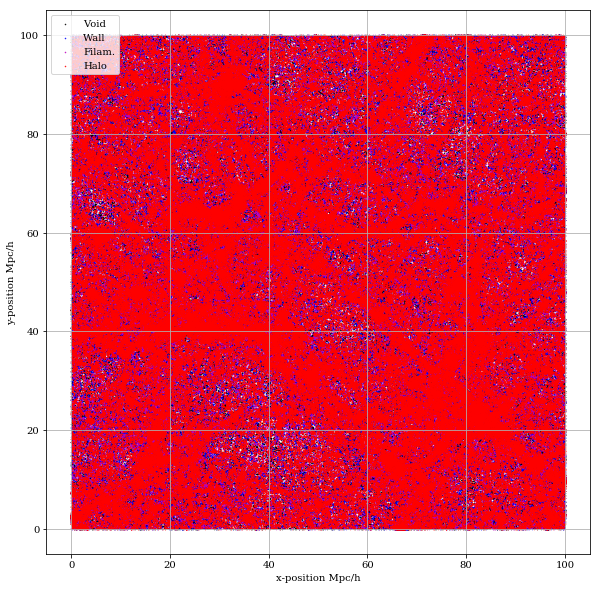

2D scatter plot time: 41.03 seconds


In [55]:
# 2D scatter plot
time_2dplot_start = time.time()

fig =  pl.figure("scatter2d", figsize=(10,10))

" Defaults to 2 dimensions in plot "
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.scatter(pos_Bvoid[:,0], pos_Bvoid[:,1], s=1, c='k', marker='.', label="Void")
ax.scatter(pos_Bwall[:,0], pos_Bwall[:,1], s=1, c='b', marker='.', label="Wall")
ax.scatter(pos_Bfila[:,0], pos_Bfila[:,1], s=1, c='m', marker='.', label="Filam.")
ax.scatter(pos_Bhalo[:,0], pos_Bhalo[:,1], s=1, c='r', marker='.', label="Halo")

# ax.plot(pos_Bvoid[:,0], pos_Bvoid[:,1],'k.', linewidth=1, label="Void")
# ax.plot(pos_Bwall[:,0], pos_Bwall[:,1],'b.', linewidth=1, label="Wall")
# ax.plot(pos_Bfila[:,0], pos_Bfila[:,1],'m.', linewidth=1, label="Filam.")
# ax.plot(pos_Bhalo[:,0], pos_Bhalo[:,1],'r.', linewidth=1, label="Halo")

ax.set_xlabel('x-position Mpc/h')
ax.set_ylabel('y-position Mpc/h')
ax.set_aspect('equal','box')
ax.legend(loc='best')
pl.grid(True)
pl.show("scatter2d")

time_2dplot_end = time.time()
print "2D scatter plot time: {0:.2f} seconds".format((time_2dplot_end - time_2dplot_start))

In [ ]:
# 3D scatter plot
time_3dplot_start = time.time()
%matplotlib tk

fig =  pl.figure("scatter3d", figsize=(20,20))
" In case of 3d "
ax  = fig.add_subplot(111, projection='3d')
# in the voice of an authorative Patrick Stewart:
" ENGAGE 3D VIZUALIZATION "
ax.scatter(pos_B[tags[box3D]==0,0], pos_B[tags[box3D]==0,1], pos_B[tags[box3D]==0,2], s=1, c='k', marker=',', label="Void")
ax.scatter(pos_B[tags[box3D]==1,0], pos_B[tags[box3D]==1,1], pos_B[tags[box3D]==1,2], s=1, c='b', marker=',', label="Wall")
ax.scatter(pos_B[tags[box3D]==2,0], pos_B[tags[box3D]==2,1], pos_B[tags[box3D]==2,2], s=1, c='m', marker=',', label="Filam.")
ax.scatter(pos_B[tags[box3D]==3,0], pos_B[tags[box3D]==3,1], pos_B[tags[box3D]==3,2], s=1, c='r', marker=',', label="Halo")
ax.set_xlabel('x-position Mpc/h')
ax.set_ylabel('y-position Mpc/h')
ax.set_zlabel('z-position Mpc/h')

gplot.axisEqual3D(ax) # Axes aspect ratio correction
pl.show("scatter3d")

time_3dplot_end = time.time()
print "3D scatter plot time: {0:.2f} seconds".format((time_3dplot_end - time_3dplot_start))

KeyboardInterrupt: 

In [60]:
print os.getcwd()

/home/idies/workspace/gravipy/pyread
